In [73]:
from pathlib import Path
import pandas as pd
import numpy as np
import pgeocode
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
# Functions for data import

def add_leading_zero_to_zipcode(item):
    item_str = str(item)  # Ensure the item is a string
    item_str = item_str.replace('.0', '') # remove trailing '.0'
    
    if len(item_str) == 4:
        return '0' + item_str
    elif len(item_str) == 3:
        return '00' + item_str
    
    elif item_str == '10072': # catch bad New York Zipcode
        return '10001'
    elif item_str == '30399': # catch bad Atlanta Zipcode
        return '30303'
    elif item_str == '94101': # catch bad San Francisco Zipcode
        return '94102'
    elif item_str == '92164': # catch bad San Diego
        return '92101'
    elif item_str == '98205': # catch bad Everett WA
        return '98201'
    elif item_str == '29573':
        return '29574'
    elif item_str == '19388':
        return '19390'
    elif item_str == '19640': # Reading PA
        return '19601'
    elif item_str == '16532': # Erie PA
        return '16501'
    elif item_str == '14645': # Rochester NY
        return '14604'
    elif item_str == '19483':
        return '19481'      # Valley Forge PA
    elif item_str == '17767':
        return '17751'      # Salona PA
    elif item_str == '45418':
        return '45390'      # Dayton OH
    elif item_str == '30330':
        return '30329'      # Atlanta GA
    elif item_str == '25965': 
        return '25976'      # Elton WV
    
    return item_str

def remove_dollar_and_convert(item):
    # Remove the dollar sign and convert to integer
    return np.int32(item.replace('$', ''))

def remove_dollar_and_convert_float(item):
    # Remove the dollar sign and convert to float
    return np.float64(item.replace('$', ''))

def convert_yes_no_to_binary(item):
    item_lower = str(item).lower()
    if item_lower == 'yes':
        result = 1
    else:
        result = 0 
    return np.int8(result)


In [39]:
# Import users from csv

users_path = Path.cwd() / 'data/sd254_users.csv'


users_columns_import = ['Birth Year', 
                        'Zipcode', 
                        'Per Capita Income - Zipcode',
                        'Yearly Income - Person', 
                        'Total Debt',
                        'FICO Score',
                        'Num Credit Cards']

user_converters = {'Zipcode': add_leading_zero_to_zipcode,
                   'Per Capita Income - Zipcode': remove_dollar_and_convert,
                   'Yearly Income - Person': remove_dollar_and_convert,
                   'Total Debt': remove_dollar_and_convert}

users_dtypes = {'Birth Year': np.uint16,
                 'FICO Score': np.uint16,
                 'Num Credit Cards': np.uint8}

users_df = pd.read_csv(users_path, 
                       usecols=users_columns_import,
                       converters=user_converters,
                       dtype=users_dtypes
                    )


users_df['User'] = users_df.index

users_df.head()


,Birth Year,Zipcode,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User
0,1966,91750,29278,59696,127613,787,5,0
1,1966,11363,37891,77254,191349,701,5,1
2,1938,91792,22681,33483,196,698,5,2
3,1957,10069,163145,249925,202328,722,4,3
4,1976,94117,53797,109687,183855,675,1,4


In [40]:
# import cards csv

cards_path = Path.cwd() / 'data/sd254_cards.csv'

cards_columns_import = ['User',	
                        'CARD INDEX',
                        'Has Chip',
                        'Cards Issued',
                        'Year PIN last Changed',
                        'Card on Dark Web'
                        ]

cards_dtypes = {'CARD INDEX': np.uint8,
                'Cards Issued': np.uint8,
                'Year PIN last Changed': np.uint16
                }

cards_conversions = {'Card on Dark Web': convert_yes_no_to_binary,
                     'Has Chip': convert_yes_no_to_binary}

cards_df = pd.read_csv(cards_path,
                       usecols=cards_columns_import,
                       dtype=cards_dtypes,
                       converters=cards_conversions
                       )

display(cards_df.head())

,User,CARD INDEX,Has Chip,Cards Issued,Year PIN last Changed,Card on Dark Web
0,0,0,1,2,2008,0
1,0,1,1,2,2014,0
2,0,2,1,2,2004,0
3,0,3,0,1,2012,0
4,0,4,1,1,2009,0


In [41]:
transactions_path = Path.cwd() / 'data/credit_card_transactions-ibm_v2.csv'

transactions_columns_import = ['User',
                               'Card',
                               'Year',
                               'Month',
                               'Day',
                               'Time',
                               'Amount',
                               'Use Chip',
                               'Merchant City',
                               'Merchant State',
                               'Zip',
                               'MCC',
                               'Errors?',
                               'Is Fraud?'
                               ]

transaction_converters = {'Zip': add_leading_zero_to_zipcode,
                           'Amount': remove_dollar_and_convert_float,
                           'Is Fraud?': convert_yes_no_to_binary
                          }


transactions_df = pd.read_csv(transactions_path,
                                usecols=transactions_columns_import,
                                converters=transaction_converters
                                )


In [42]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          float64
 7   Use Chip        object 
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             object 
 11  MCC             int64  
 12  Errors?         object 
 13  Is Fraud?       int8   
dtypes: float64(1), int64(6), int8(1), object(6)
memory usage: 2.4+ GB


In [43]:
transactions_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,La Verne,CA,91750,5300,NaN,0
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,Monterey Park,CA,91754,5651,NaN,0
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,La Verne,CA,91750,5912,NaN,0


In [44]:
# inconsistent Merchant City ONLINE and Use Chip Online Transaction
transactions_df.loc[((transactions_df['Merchant City'] == 'ONLINE') & (transactions_df['Use Chip'] != 'Online Transaction')), 'Use Chip'].value_counts()

Use Chip
Chip Transaction    7601
Name: count, dtype: int64

In [45]:
transactions_users_500_df = transactions_df.loc[transactions_df['User'] < 500]
transactions_test_df = transactions_df.loc[transactions_df['User'] < 100]

In [85]:
# transactions_users_500_df.to_csv('data/transactions_users_500.csv', index=False)
transactions_test_df.to_csv('data/transactions_users_100..csv', index=False)

In [47]:
# merge datasets

# merge_step_1 = transactions_users_500_df.merge(users_df, how='inner', on='User')
merge_step_1 = transactions_test_df.merge(users_df, how='inner', on='User')

merged_df = merge_step_1.merge(cards_df, how='inner', left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258233 entries, 0 to 1258232
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   User                         1258233 non-null  int64  
 1   Card                         1258233 non-null  int64  
 2   Year                         1258233 non-null  int64  
 3   Month                        1258233 non-null  int64  
 4   Day                          1258233 non-null  int64  
 5   Time                         1258233 non-null  object 
 6   Amount                       1258233 non-null  float64
 7   Use Chip                     1258233 non-null  object 
 8   Merchant City                1258233 non-null  object 
 9   Merchant State               1075669 non-null  object 
 10  Zip                          1258233 non-null  object 
 11  MCC                          1258233 non-null  int64  
 12  Errors?                      20054 non-nul

In [48]:
# add column to define whether international
merged_df['International'] = (merged_df['Merchant State'].str.len() > 2).astype(np.int8)

# add column for online transaction
merged_df['Online'] = (transactions_df['Merchant City'] == 'ONLINE').astype(np.int8)

# add column for age at transaction
merged_df['Age_at_transaction'] = (merged_df['Year'] - merged_df['Birth Year']).astype(np.int16)

# create income-to-debt
merged_df['income_to_debt'] = merged_df['Yearly Income - Person'] / (merged_df['Total Debt'] + 0.001)

# create a date-time column
merged_df['datetime'] = pd.to_datetime(merged_df['Year'].astype(str) + '-' + 
                                merged_df['Month'].astype(str) + '-' + 
                                merged_df['Day'].astype(str) + ' ' + 
                                merged_df['Time'])

# create day of week column
merged_df['day_of_week'] = merged_df['datetime'].dt.dayofweek.astype(np.int8)

# Convert datetime to Unix timestamp
merged_df['timestamp'] = merged_df['datetime'].astype(int) / 10**9  # Convert to seconds

In [49]:
# Put times into bins of time-of-day

# Define the bins and their corresponding labels
time_bins = [0, 6, 12, 18, 22, 24]
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']

# Categorize the hours into bins
merged_df['time_of_day'] = pd.cut(merged_df['datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False, include_lowest=True, ordered=False)


In [50]:
# create filters and lists of zipcodes to find distance with
distance_candidates = merged_df['Zip'].str.len() == 5
international_filters = merged_df['International'] == 1
online_filters = merged_df['Online'] == 1


merchant_zip_list = merged_df.loc[distance_candidates, 'Zip'].to_list()
user_zip_list = merged_df.loc[distance_candidates, 'Zipcode'].to_list()

# use pgeocode to calculate distances
dist = pgeocode.GeoDistance('us')
distances = dist.query_postal_code(user_zip_list, merchant_zip_list)

avg_distance = np.mean(distances)
max_distance = np.max(distances)


# initiate distance attribute with average distance
merged_df['distances'] = avg_distance

# populate distances
merged_df.loc[distance_candidates, 'distances'] = distances
merged_df.loc[international_filters, 'distances'] = max_distance
# merged_df.loc[distance_candidates, 'problem_dist'] = np.isnan(distances)


In [51]:
# # Define the bins and their labels
# # a word of caution: https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when

# age_bins = [0, 18, 25, 35, 45, 60, 100]
# age_labels = ['Under 18', '18-25', '26-35', '36-45', '46-60', 'Over 60']

# # Bin the 'Current Age' column
# merged_df['Age_Group_at_Transaction'] = pd.cut(merged_df['Age_at_transaction'], bins=age_bins, labels=age_labels, right=False)

# # Drop the 'Current Age' column after binning
# merged_df = merged_df.drop(columns=['Age_at_transaction'])

In [52]:
merged_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Birth Year,Zipcode,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,CARD INDEX,Has Chip,Cards Issued,Year PIN last Changed,Card on Dark Web,International,Online,Age_at_transaction,income_to_debt,datetime,day_of_week,timestamp,time_of_day,distances
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,La Verne,CA,91750,5300,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-01 06:21:00,6,1.030861e+09,Morning,0.000000
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-01 06:42:00,6,1.030863e+09,Morning,33.540588
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-02 06:22:00,0,1.030948e+09,Morning,33.540588
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,Monterey Park,CA,91754,5651,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-02 17:45:00,0,1.030989e+09,Afternoon,33.540588
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,La Verne,CA,91750,5912,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-03 06:23:00,1,1.031034e+09,Morning,0.000000


In [53]:
columns_to_drop = ['Card',
                   'User',
                   'Year',
                   'Month',
                   'Birth Year',
                   'Day',
                   'Time',
                   'Merchant City',
                   'Zip',
                   'Zipcode',
                   'CARD INDEX',
                   'Year PIN last Changed',
                   'MCC',
                   'datetime',
                   'Card on Dark Web'
                   ]

merged_and_drop_df = merged_df.drop(columns=columns_to_drop, axis=1)

# Filter out negative amounts
merged_and_drop_df = merged_and_drop_df.loc[merged_and_drop_df['Amount'] > 0.0]

# replace NaN Errors with No Error
merged_and_drop_df['Errors?'] = merged_and_drop_df['Errors?'].fillna('No Error')

# replace NaN in Merchant State with Online
merged_and_drop_df['Merchant State'] = merged_and_drop_df['Merchant State'].fillna('Online')

merged_and_drop_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258228,28.02,Chip Transaction,TX,No Error,0,30475,62135,75209,676,2,1,1,0,0,22,0.826164,2,1.582732e+09,Afternoon,0.000000
1258229,15.25,Chip Transaction,TX,No Error,0,30475,62135,75209,676,2,1,1,0,0,22,0.826164,3,1.582807e+09,Afternoon,0.000000
1258230,40.00,Chip Transaction,CO,No Error,0,30475,62135,75209,676,2,1,1,0,0,22,0.826164,3,1.582834e+09,Evening,1044.223953
1258231,146.31,Chip Transaction,CO,No Error,0,30475,62135,75209,676,2,1,1,0,0,22,0.826164,4,1.582872e+09,Morning,1044.223953


In [54]:
merged_and_drop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1203635 entries, 0 to 1258232
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   Amount                       1203635 non-null  float64 
 1   Use Chip                     1203635 non-null  object  
 2   Merchant State               1203635 non-null  object  
 3   Errors?                      1203635 non-null  object  
 4   Is Fraud?                    1203635 non-null  int8    
 5   Per Capita Income - Zipcode  1203635 non-null  int32   
 6   Yearly Income - Person       1203635 non-null  int32   
 7   Total Debt                   1203635 non-null  int32   
 8   FICO Score                   1203635 non-null  uint16  
 9   Num Credit Cards             1203635 non-null  uint8   
 10  Has Chip                     1203635 non-null  int8    
 11  Cards Issued                 1203635 non-null  uint8   
 12  International                1203

In [55]:
# Define categorical and numerical columns
categorical_cols = ['Use Chip',
                    'Merchant State',
                    'Errors?',
                    'Is Fraud?',
                    'Has Chip',
                    'International',
                    'Online',
                    'day_of_week',
                    'time_of_day']
numerical_cols = ['Amount',
                    'Per Capita Income - Zipcode',
                    'Yearly Income - Person',
                    'Total Debt',
                    'FICO Score',
                    'Num Credit Cards',
                    'Cards Issued',
                    'Age_at_transaction',
                    'income_to_debt',
                    'timestamp',
                    'distances']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])




In [56]:
# Define the model - option 2
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=10, criterion='gini', random_state=42))
])

In [57]:
merged_and_drop_df.loc[merged_and_drop_df['Merchant State'].isnull(), 'Online'].value_counts()

Series([], Name: count, dtype: int64)

In [58]:
merged_and_drop_df['Merchant State'].unique()

array(['CA', 'Online', 'NE', 'IL', 'MO', 'Switzerland', 'IA', 'TX',
       'Estonia', 'NJ', 'NV', 'NY', 'Japan', 'AZ', 'UT', 'FL', 'MI',
       'Mexico', 'WA', 'OH', 'Dominican Republic', 'NM', 'China', 'SC',
       'AK', 'PA', 'VA', 'Portugal', 'HI', 'CT', 'MA', 'MN', 'CO',
       'Italy', 'GA', 'Philippines', 'Jamaica', 'AR', 'Canada', 'OR',
       'WI', 'NC', 'France', 'WV', 'Norway', 'ME', 'NH', 'VT', 'MD', 'AL',
       'KY', 'TN', 'MS', 'New Zealand', 'Netherlands', 'KS', 'ND', 'DC',
       'Sierra Leone', 'Haiti', 'MT', 'South Korea', 'Spain', 'OK',
       'Algeria', 'Egypt', 'WY', 'ID', 'Indonesia', 'RI',
       'United Kingdom', 'Colombia', 'South Africa', 'IN', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'LA', 'Germany', 'Czech Republic', 'India', 'Poland', 'DE',
       'Costa Rica', 'Denmark', 'Bangladesh', 'Macedonia', 'Nigeria',
       'SD', 'Tuvalu', 'Irelan

## Neuro Network

In [59]:
# Re-writing the dataframe
model_df = merged_and_drop_df
# Convert categorical data to numeric with `pd.get_dummies`
dummies = pd.get_dummies(model_df)
dummies.head()

,Amount,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,distances,Use Chip_Chip Transaction,Use Chip_Online Transaction,Use Chip_Swipe Transaction,Merchant State_AK,Merchant State_AL,Merchant State_AR,Merchant State_AZ,Merchant State_Algeria,Merchant State_Argentina,Merchant State_Aruba,Merchant State_Australia,Merchant State_Austria,Merchant State_Bangladesh,Merchant State_Barbados,Merchant State_Belgium,Merchant State_Benin,Merchant State_Brazil,Merchant State_CA,Merchant State_CO,Merchant State_CT,Merchant State_Canada,Merchant State_China,Merchant State_Colombia,Merchant State_Costa Rica,Merchant State_Croatia,Merchant State_Czech Republic,Merchant State_DC,Merchant State_DE,Merchant State_Denmark,Merchant State_Dominican Republic,Merchant State_Egypt,Merchant State_Estonia,Merchant State_FL,Merchant State_Finland,Merchant State_France,Merchant State_GA,Merchant State_Germany,Merchant State_Ghana,Merchant State_Greece,Merchant State_Guatemala,Merchant State_HI,Merchant State_Haiti,Merchant State_Hong Kong,Merchant State_Hungary,Merchant State_IA,Merchant State_ID,Merchant State_IL,Merchant State_IN,Merchant State_India,Merchant State_Indonesia,Merchant State_Ireland,Merchant State_Israel,Merchant State_Italy,Merchant State_Jamaica,Merchant State_Japan,Merchant State_KS,Merchant State_KY,Merchant State_LA,Merchant State_Latvia,Merchant State_Lithuania,Merchant State_MA,Merchant State_MD,Merchant State_ME,Merchant State_MI,Merchant State_MN,Merchant State_MO,Merchant State_MS,Merchant State_MT,Merchant State_Macedonia,Merchant State_Malaysia,Merchant State_Mexico,Merchant State_Micronesia,Merchant State_Mongolia,Merchant State_NC,Merchant State_ND,Merchant State_NE,Merchant State_NH,Merchant State_NJ,Merchant State_NM,Merchant State_NV,Merchant State_NY,Merchant State_Netherlands,Merchant State_New Zealand,Merchant State_Nigeria,Merchant State_Norway,Merchant State_OH,Merchant State_OK,Merchant State_OR,Merchant State_Oman,Merchant State_Online,Merchant State_PA,Merchant State_Pakistan,Merchant State_Papua New Guinea,Merchant State_Peru,Merchant State_Philippines,Merchant State_Poland,Merchant State_Portugal,Merchant State_RI,Merchant State_Russia,Merchant State_SC,Merchant State_SD,Merchant State_Saudi Arabia,Merchant State_Serbia,Merchant State_Sierra Leone,Merchant State_Singapore,Merchant State_Slovakia,Merchant State_Slovenia,Merchant State_South Africa,Merchant State_South Korea,Merchant State_Spain,Merchant State_Sweden,Merchant State_Switzerland,Merchant State_TN,Merchant State_TX,Merchant State_Taiwan,Merchant State_Thailand,Merchant State_The Bahamas,Merchant State_Turkey,Merchant State_Tuvalu,Merchant State_UT,Merchant State_United Arab Emirates,Merchant State_United Kingdom,Merchant State_VA,Merchant State_VT,Merchant State_Vatican City,Merchant State_Vietnam,Merchant State_WA,Merchant State_WI,Merchant State_WV,Merchant State_WY,Errors?_Bad CVV,"Errors?_Bad CVV,Insufficient Balance","Errors?_Bad CVV,Technical Glitch",Errors?_Bad Card Number,"Errors?_Bad Card Number,Bad CVV","Errors?_Bad Card Number,Bad Expiration","Errors?_Bad Card Number,Bad Expiration,Technical Glitch","Errors?_Bad Card Number,Insufficient Balance",Errors?_Bad Expiration,"Errors?_Bad Expiration,Bad CVV","Errors?_Bad Expiration,Insufficient Balance","Errors?_Bad Expiration,Technical Glitch",Errors?_Bad PIN,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_No Error,Errors?_Technical Glitch,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,134.09,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,0.000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,Fa

In [60]:
model_df['Is Fraud?'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [61]:
# Splitting  preprocessed data 
y = dummies['Is Fraud?'].values
X = dummies.drop(columns='Is Fraud?').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [62]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [63]:
# Defining the model
features_total = len(X_train[0])
nodes_layer1 = 60
nodes_layer2 = 30
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = nodes_layer1, input_dim = features_total, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = 'relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

# Check the structure of the model
nn.summary()

/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 60)             │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,061 (47.11 KB)

 Trainable params: 12,061 (47.11 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compiling the model
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [65]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9980 - loss: 0.0118
Epoch 2/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - accuracy: 0.9991 - loss: 0.0055
Epoch 3/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.9991 - loss: 0.0053
Epoch 4/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - accuracy: 0.9992 - loss: 0.0049
Epoch 5/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.9992 - loss: 0.0053
Epoch 6/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - accuracy: 0.9991 - loss: 0.0052
Epoch 7/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - accuracy: 0.9992 - loss: 0.0057
Epoch 8/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 99s 4ms/step - accuracy: 0.9991 - loss: 0.0048
Epoch 9/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9992 - loss: 0.0052
Epoch 10/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9991 - loss: 0.0054
Epoch 11/50
28211/28211 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9992 - loss: 0.

In [66]:
# Evaluating the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9404/9404 - 9s - 962us/step - accuracy: 0.9992 - loss: 0.0055
Loss: 0.005510378163307905, Accuracy: 0.9992190599441528


In [67]:
# Exporting the model to HDF5 file
nn.save('Models/nnmodel_aleks.h5')

In [77]:
# Loading the model
loaded_model_1 = tf.keras.models.load_model("Models/nnmodel_aleks.h5")

# Checking the structure
loaded_model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 60)             │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,063 (47.12 KB)

 Trainable params: 12,061 (47.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [78]:
# Saving the model with joblib
model_filename = 'models/nnmodel_aleks_joblib.joblib'
joblib.dump(loaded_model, model_filename) 
print(f"Model saved to {model_filename}")

# Load the model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully")

# Loading the data
#data_path = 'data/transactions_users_100..csv'


Model saved to Models/nnmodel_aleks_joblib.joblib
Model loaded successfully


In [90]:
X_test.dtype

dtype('O')

In [94]:
array = X_test.astype(np.float32)

In [96]:
array

array([[9.20000e-01, 1.86660e+04, 3.80590e+04, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [7.38300e+01, 2.46110e+04, 5.01790e+04, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [4.83700e+01, 1.32630e+04, 1.63420e+04, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       ...,
       [3.92400e+01, 5.37970e+04, 1.09687e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.57000e+00, 1.32630e+04, 1.63420e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.35300e+01, 1.87300e+04, 3.81900e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]], dtype=float32)

In [92]:
X_train

array([[27.39, 20599, 41997, ..., False, False, False],
       [17.11, 34659, 70673, ..., True, False, False],
       [6.59, 32078, 65403, ..., False, False, False],
       ...,
       [20.79, 95039, 193773, ..., False, False, False],
       [15.28, 19712, 40194, ..., False, False, False],
       [50.76, 22681, 33483, ..., False, True, False]], dtype=object)

In [97]:
y_pred_loaded = loaded_model.predict(array)

9404/9404 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step


In [98]:
# Evaluation
print('\nClassification Report (Neural Network):')
print(classification_report(y_test, y_pred_loaded))
print('Confusion Matrix (Neural Network):')
print(confusion_matrix(y_test, y_pred_loaded))
print('Accuracy Score (Neural Network):')
print(accuracy_score(y_test, y_pred_loaded))


Classification Report (Neural Network):


/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    300614
           1       0.00      0.00      0.00       295

    accuracy                           1.00    300909
   macro avg       0.50      0.50      0.50    300909
weighted avg       1.00      1.00      1.00    300909

Confusion Matrix (Neural Network):
[[300614      0]
 [   295      0]]
Accuracy Score (Neural Network):
0.9990196371660536


9404/9404 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step


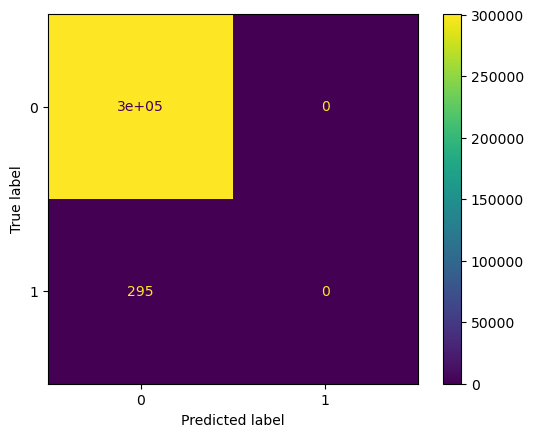

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting on the training set
y_test_pred = loaded_model.predict(array)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()